
======================================== STEP 1 ========================================

Directory created: C:\Users\Katrina\AppData\Local\Temp\trial_pp
Directory created: C:\Users\Katrina\AppData\Local\Temp\trial_itt

PP Trial: TrialSequence(estimand=PP, directory=C:\Users\Katrina\AppData\Local\Temp\trial_pp, id_col=None, period_col=None, treatment_col=None, outcome_col=None, eligible_col=None)

ITT Trial: TrialSequence(estimand=ITT, directory=C:\Users\Katrina\AppData\Local\Temp\trial_itt, id_col=None, period_col=None, treatment_col=None, outcome_col=None, eligible_col=None)

======================================== STEP 2 ========================================

Loaded data preview:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.25

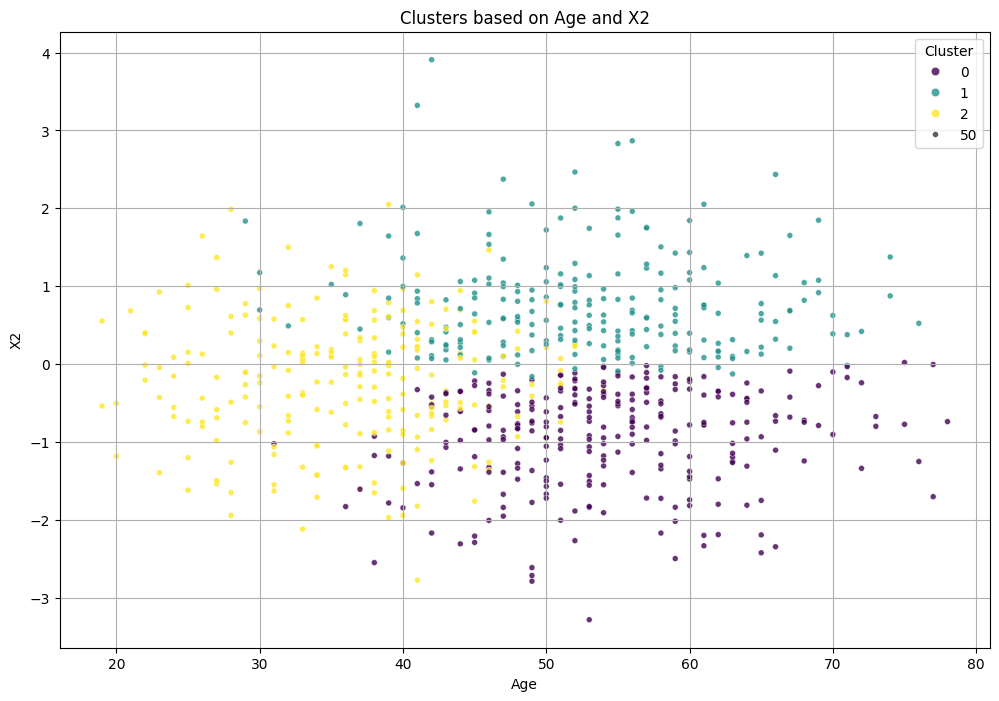


Patients clustered into 3 groups based on features: ['age', 'x2', 'x4']
Cluster counts:
cluster
0    4544
1    3797
2    2608
Name: count, dtype: int64
Updated columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'cluster']
Cluster centers (scaled):
[[ 0.53112156 -0.77943753 -0.32738206]
 [ 0.42107818  0.94201607 -0.45639407]
 [-1.03254414 -0.05145306  0.83415605]]
Cluster centers (original scale):
[[54.375      -0.95054589 -0.60470574]
 [53.07359307  0.76550967 -0.73474304]
 [35.8826087  -0.22484419  0.56606337]]

Visualizing clusters (Age vs X2)...


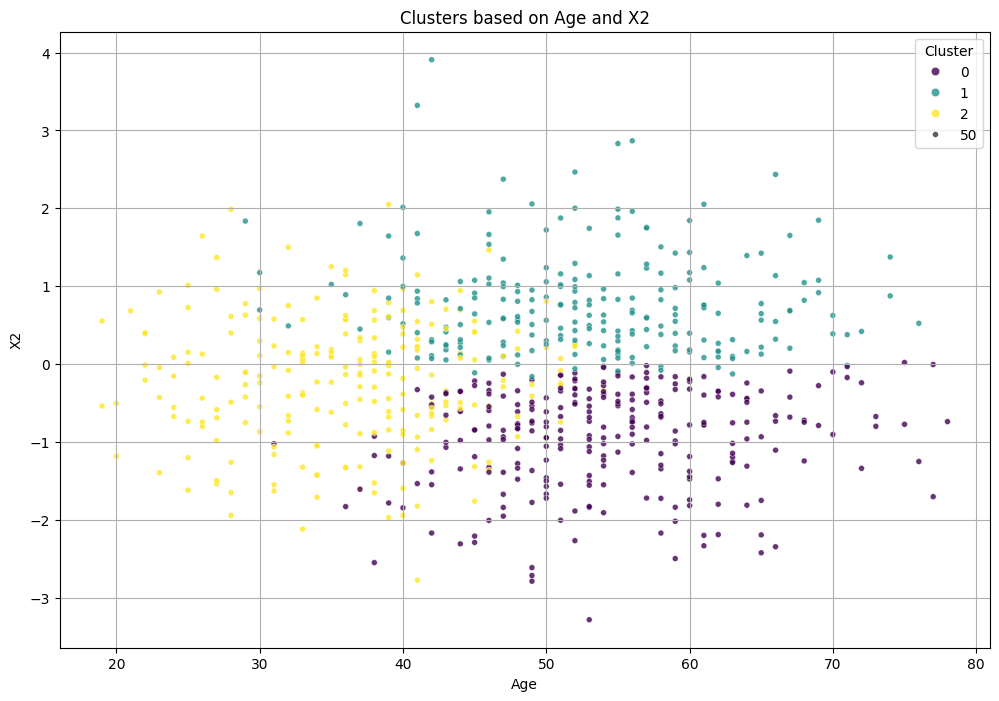


======================================== STEP 3.1 ========================================


3.1 Censoring due to treatment switching
Fitting switch weight models by cluster...
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\numerator_cluster_2_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\denominator_cluster_2_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\numerator_cluster_1_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\denominator_cluster_1_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\numerator_cluster_0_model.pkl
Model saved to C:\Users\Katrina\AppData\Local\Temp\trial_pp\denominator_cluster_0_model.pkl
Switch weight models fitted.
Switch weight models are not applicable for ITT estimand. Skipping.

======================================== STEP 3.2 ========================================


3.2 Other informative censoring
Setting censor weight model with data columns: ['id',

C:\Users\Katrina\AppData\Roaming\Python\Python313\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\Katrina\AppData\Roaming\Python\Python313\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\Katrina\AppData\Roaming\Python\Python313\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


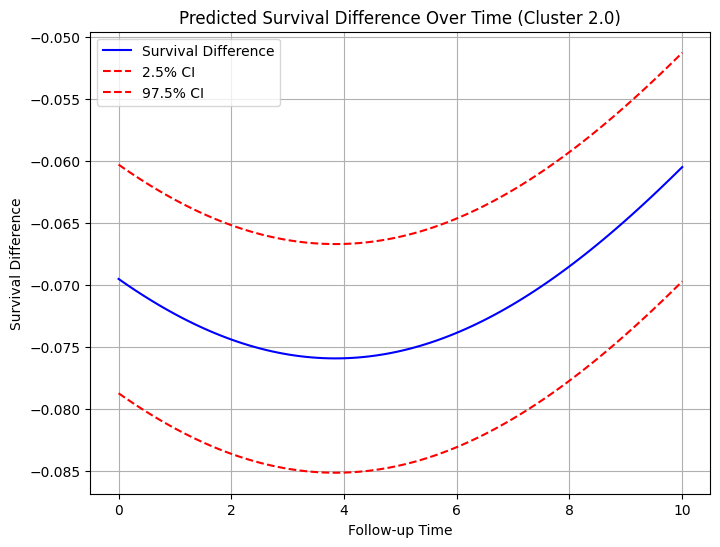

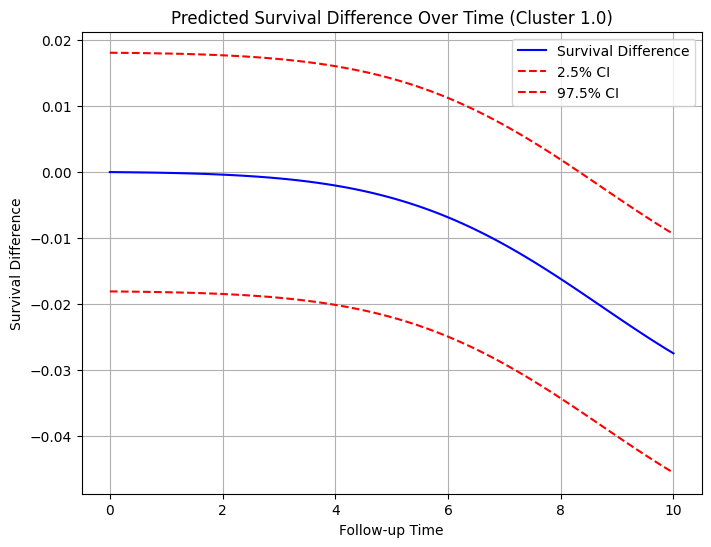

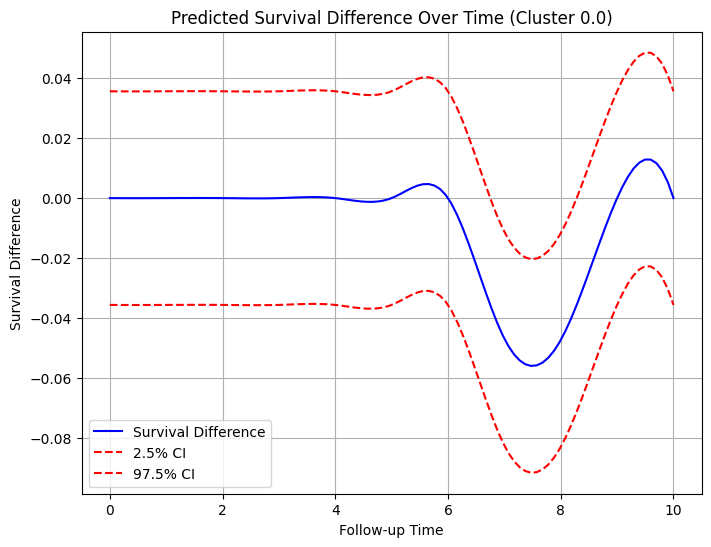

In [24]:
import os
import tempfile
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import pickle
from typing import Optional, Dict, Union
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

class TrialSequence:
    def __init__(self, estimand: str):
        self.estimand = estimand.upper()
        self.directory: Optional[str] = None
        self.data: Optional[pd.DataFrame] = None
        self.id_col: Optional[str] = None
        self.period_col: Optional[str] = None
        self.treatment_col: Optional[str] = None
        self.outcome_col: Optional[str] = None
        self.eligible_col: Optional[str] = None
        self.switch_weights: Optional[Dict] = None
        self.censor_weights: Optional[Dict] = None
        self.outcome_model = None
        self.cluster_centers_ = None  # Store cluster centers

    def create_directory(self, base_dir: Optional[str] = None) -> None:
        if base_dir is None:
            base_dir = tempfile.gettempdir()
        dir_name = f"trial_{self.estimand.lower()}"
        self.directory = os.path.join(base_dir, dir_name)
        os.makedirs(self.directory, exist_ok=True)
        print(f"Directory created: {self.directory}")

    def set_data(self, data: pd.DataFrame, id_col: str, period_col: str, treatment_col: str, 
                outcome_col: str, eligible_col: str) -> None:
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        print(f"\nData assigned for {self.estimand} trial")
        print(f"Columns: {self.data.columns.tolist()}")
        print(f"Treatment counts:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts:\n{self.data[self.outcome_col].value_counts()}")
        print(f"First few rows:\n{self.data.head()}")

    def _fit_logit_model(self, data: pd.DataFrame, formula: str, label: str, 
                        save_path: Optional[str] = None) -> sm.Logit:
        y, X = patsy.dmatrices(formula, data, return_type="dataframe")
        try:
            model = sm.Logit(y, X).fit(disp=0)
        except Exception as e:
            print(f"Error fitting logit model for {label}: {e}")
            raise
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            model_file = os.path.join(save_path, f"{label}_model.pkl")
            with open(model_file, "wb") as f:
                pickle.dump(model, f)
            print(f"Model saved to {model_file}")
        return model

    def set_switch_weight_model(self, numerator_formula: str, denominator_formula: str, 
                              save_path: Optional[str] = None, use_clusters: bool = False) -> None:
        if self.estimand == "ITT":
            print("Switch weight models are not applicable for ITT estimand. Skipping.")
            return
        if self.data is None:
            raise ValueError("Data must be set before fitting models.")
        print("\n3.1 Censoring due to treatment switching")
        
        if use_clusters and 'cluster' in self.data.columns:
            print("Fitting switch weight models by cluster...")
            numerator_models = {}
            denominator_models = {}
            for cluster in self.data['cluster'].unique():
                if cluster == -1:  # Skip rows not assigned to a cluster
                    continue
                cluster_data = self.data[self.data['cluster'] == cluster]
                if cluster_data.empty:
                    continue
                numerator_models[cluster] = self._fit_logit_model(
                    cluster_data, f"{self.treatment_col} ~ {numerator_formula} + C(cluster)", 
                    f"numerator_cluster_{cluster}", save_path
                )
                denominator_models[cluster] = self._fit_logit_model(
                    cluster_data, f"{self.treatment_col} ~ {denominator_formula} + C(cluster)", 
                    f"denominator_cluster_{cluster}", save_path
                )
            self.switch_weights = {
                "numerator": numerator_models,
                "denominator": denominator_models,
                "numerator_formula": f"{self.treatment_col} ~ {numerator_formula} + C(cluster)",
                "denominator_formula": f"{self.treatment_col} ~ {denominator_formula} + C(cluster)"
            }
        else:
            numerator_model = self._fit_logit_model(self.data, f"{self.treatment_col} ~ {numerator_formula}", 
                                                  "numerator", save_path)
            denominator_model = self._fit_logit_model(self.data, f"{self.treatment_col} ~ {denominator_formula}", 
                                                    "denominator", save_path)
            self.switch_weights = {
                "numerator": numerator_model,
                "denominator": denominator_model,
                "numerator_formula": f"{self.treatment_col} ~ {numerator_formula}",
                "denominator_formula": f"{self.treatment_col} ~ {denominator_formula}"
            }
        print("Switch weight models fitted.")

    def set_censor_weight_model(self, censor_event: str, numerator_formula: str, 
                              denominator_formula: str, pool_models: str = "none", 
                              save_path: Optional[str] = None, use_clusters: bool = False) -> None:
        if self.data is None:
            raise ValueError("Data must be set before fitting models.")
        print("\n3.2 Other informative censoring")
        data = self.data.copy()
        print(f"Setting censor weight model with data columns: {data.columns.tolist()}")
        if use_clusters and 'cluster' in self.data.columns:
            print("Fitting censor weight models by cluster...")
            numerator_models = {}
            denominator_models = {}
            for cluster in self.data['cluster'].unique():
                if cluster == -1:  # Skip rows not assigned to a cluster
                    continue
                cluster_data = self.data[self.data['cluster'] == cluster]
                if cluster_data.empty:
                    continue
                numerator_models[cluster] = self._fit_logit_model(
                    cluster_data, f"{censor_event} ~ {numerator_formula} + C(cluster)", 
                    f"numerator_cluster_{cluster}", save_path
                )
                denominator_models[cluster] = self._fit_logit_model(
                    cluster_data, f"{censor_event} ~ {denominator_formula} + C(cluster)", 
                    f"denominator_cluster_{cluster}", save_path
                )
            self.censor_weights = {
                "numerator": numerator_models,
                "denominator": denominator_models,
                "numerator_formula": f"{censor_event} ~ {numerator_formula} + C(cluster)",
                "denominator_formula": f"{censor_event} ~ {denominator_formula} + C(cluster)",
                "pool_models": pool_models
            }
        elif pool_models == "numerator":
            numerator_model = self._fit_logit_model(data, f"{censor_event} ~ {numerator_formula}", 
                                                  "numerator_pooled", save_path)
            denominator_model = self._fit_logit_model(data, f"{censor_event} ~ {denominator_formula}", 
                                                    "denominator_pooled", save_path)
            self.censor_weights = {
                "numerator": numerator_model,
                "denominator": denominator_model,
                "numerator_formula": f"{censor_event} ~ {numerator_formula}",
                "denominator_formula": f"{censor_event} ~ {denominator_formula}",
                "pool_models": pool_models
            }
        else:
            numerator_model = {treatment: self._fit_logit_model(data[data[self.treatment_col] == treatment],
                                                              f"{censor_event} ~ {numerator_formula}",
                                                              f"numerator_treatment_{treatment}", save_path)
                             for treatment in data[self.treatment_col].unique()}
            denominator_model = {treatment: self._fit_logit_model(data[data[self.treatment_col] == treatment],
                                                                f"{censor_event} ~ {denominator_formula}",
                                                                f"denominator_treatment_{treatment}", save_path)
                               for treatment in data[self.treatment_col].unique()}
            self.censor_weights = {
                "numerator": numerator_model,
                "denominator": denominator_model,
                "numerator_formula": f"{censor_event} ~ {numerator_formula}",
                "denominator_formula": f"{censor_event} ~ {denominator_formula}",
                "pool_models": pool_models
            }
        print("Censor weight models fitted.")
        print(f"self.censor_weights keys: {self.censor_weights.keys()}")

    def calculate_weights(self) -> None:
        if self.data is None:
            raise ValueError("Data must be set before calculating weights")
        if self.switch_weights and self.estimand != "ITT":
            print("\nCalculating weights for treatment switching models...")
            if isinstance(self.switch_weights["numerator"], dict):  # Cluster-specific models
                switch_weights = np.zeros(len(self.data))
                for cluster in self.switch_weights["numerator"].keys():
                    mask = self.data['cluster'] == cluster
                    if not mask.any():
                        continue
                    X_num = patsy.dmatrix(self.switch_weights["numerator_formula"].split("~")[1], 
                                        self.data[mask], return_type="dataframe")
                    X_denom = patsy.dmatrix(self.switch_weights["denominator_formula"].split("~")[1], 
                                          self.data[mask], return_type="dataframe")
                    num_pred = self.switch_weights["numerator"][cluster].predict(X_num)
                    denom_pred = self.switch_weights["denominator"][cluster].predict(X_denom)
                    switch_weights[mask] = num_pred / denom_pred
                self.data["switch_weight"] = switch_weights
            else:
                X_num = patsy.dmatrix(self.switch_weights["numerator_formula"].split("~")[1], 
                                    self.data, return_type="dataframe")
                X_denom = patsy.dmatrix(self.switch_weights["denominator_formula"].split("~")[1], 
                                      self.data, return_type="dataframe")
                num_pred = self.switch_weights["numerator"].predict(X_num)
                denom_pred = self.switch_weights["denominator"].predict(X_denom)
                self.data["switch_weight"] = num_pred / denom_pred
            print("Weights for treatment switching models calculated and stored as 'switch_weight'.")
        if self.censor_weights:
            print("\nCalculating weights for censor models...")
            if isinstance(self.censor_weights["numerator"], dict):
                censor_weights = np.zeros(len(self.data))
                for cluster in self.censor_weights["numerator"].keys() if 'cluster' in self.data.columns else self.censor_weights["numerator"].keys():
                    mask = self.data['cluster'] == cluster if 'cluster' in self.data.columns else self.data[self.treatment_col] == cluster
                    if not mask.any():
                        continue
                    X_num = patsy.dmatrix(self.censor_weights["numerator_formula"].split("~")[1], 
                                        self.data[mask], return_type="dataframe")
                    X_denom = patsy.dmatrix(self.censor_weights["denominator_formula"].split("~")[1], 
                                          self.data[mask], return_type="dataframe")
                    num_pred = self.censor_weights["numerator"][cluster].predict(X_num)
                    denom_pred = self.censor_weights["denominator"][cluster].predict(X_denom)
                    censor_weights[mask] = num_pred / denom_pred
            else:
                X_num = patsy.dmatrix(self.censor_weights["numerator_formula"].split("~")[1], 
                                    self.data, return_type="dataframe")
                X_denom = patsy.dmatrix(self.censor_weights["denominator_formula"].split("~")[1], 
                                      self.data, return_type="dataframe")
                num_pred = self.censor_weights["numerator"].predict(X_num)
                denom_pred = self.censor_weights["denominator"].predict(X_denom)
                censor_weights = num_pred / denom_pred
            self.data["censor_weight"] = censor_weights
            print("Weights for censor models calculated and stored as 'censor_weight'.")
            print(f"Columns after weight calculation: {self.data.columns.tolist()}")

    def show_weight_models(self) -> None:
        if self.switch_weights and self.estimand != "ITT":
            print("\nWeight Models for Treatment Switching")
            print("--------------------------------------")
            for key in ["numerator", "denominator"]:
                print(f"\nModel: {key.capitalize()} model")
                if isinstance(self.switch_weights[key], dict):
                    for cluster, sub_model in self.switch_weights[key].items():
                        print(f"\nCluster: {cluster}")
                        print(sub_model.summary())
                else:
                    print(self.switch_weights[key].summary())
        if self.censor_weights:
            print("\nWeight Models for Informative Censoring")
            print("--------------------------------------")
            for key in ["numerator", "denominator"]:
                print(f"\nModel: {key.capitalize()} model")
                if isinstance(self.censor_weights[key], dict):
                    for cluster_or_treatment, sub_model in self.censor_weights[key].items():
                        print(f"\n{'Cluster' if 'cluster' in self.data.columns else 'Treatment'}: {cluster_or_treatment}")
                        print(sub_model.summary())
                else:
                    print(self.censor_weights[key].summary())

    def set_outcome_model(self, adjustment_terms: Optional[str] = None) -> None:
        if self.data is None:
            raise ValueError("Data must be set before specifying the outcome model.")
        # Include cluster as an adjustment term if it exists
        cluster_term = " + C(cluster)" if 'cluster' in self.data.columns and adjustment_terms else ""
        formula = f"{self.outcome_col} ~ {self.treatment_col}" if not adjustment_terms else f"{self.outcome_col} ~ {self.treatment_col} + {adjustment_terms}{cluster_term}"
        self.outcome_model = smf.logit(formula, data=self.data).fit()
        print(f"\nOutcome model specified with formula: {formula}")
        print(self.outcome_model.summary())

    def __repr__(self) -> str:
        switch_weight_info = ""
        if self.switch_weights and self.estimand != "ITT":
            models_fitted = all(self.switch_weights.get(k) for k in ["numerator", "denominator"])
            switch_weight_info = (f"\n - Numerator formula: {self.switch_weights['numerator_formula']} \n"
                                f" - Denominator formula: {self.switch_weights['denominator_formula']} \n"
                                f" - Model fitter type: te_stats_glm_logit \n"
                                f" - Weight models {'fitted' if models_fitted else 'not fitted. Use calculate_weights()'}")
        censor_weight_info = ""
        if self.censor_weights:
            models_fitted = all(self.censor_weights.get(k) for k in ["numerator", "denominator"])
            censor_weight_info = (f"\n - Numerator formula: {self.censor_weights['numerator_formula']} \n"
                                f" - Denominator formula: {self.censor_weights['denominator_formula']} \n"
                                f" - Model fitter type: te_stats_glm_logit \n"
                                f" - Weight models {'fitted' if models_fitted else 'not fitted. Use calculate_weights()'}"
                                f"\n - Numerator pooling: {self.censor_weights['pool_models']}")
        return (f"TrialSequence(estimand={self.estimand}, directory={self.directory}, "
                f"id_col={self.id_col}, period_col={self.period_col}, "
                f"treatment_col={self.treatment_col}, outcome_col={self.outcome_col}, "
                f"eligible_col={self.eligible_col})" + switch_weight_info + censor_weight_info)

    def set_expansion_options(self, chunk_size: int = 500):
        self.chunk_size = chunk_size
        print(f"\nExpansion options set: chunk_size = {self.chunk_size}")

    def expand_trials(self, max_period=10):
        if self.data is None:
            raise ValueError("Data must be set before expanding trials.")
        expanded_data = []
        for id_, group in self.data.groupby(self.id_col):
            if not (group[self.period_col] == 0).any():
                continue
            baseline = group[group[self.period_col] == 0].iloc[0]
            initial_treatment = baseline[self.treatment_col]
            initial_x2 = baseline['x2']
            for t in range(max_period + 1):
                new_row = baseline.copy()
                new_row[self.period_col] = t
                new_row["followup_time"] = t
                new_row[self.treatment_col] = initial_treatment
                new_row['x2'] = initial_x2
                censored_at_t = group[group[self.period_col] <= t]["censored"].max()
                if censored_at_t == 1:
                    new_row['censored'] = 1
                    expanded_data.append(new_row)
                    break
                outcome_at_t = group[group[self.period_col] <= t][self.outcome_col].max()
                new_row[self.outcome_col] = outcome_at_t
                if outcome_at_t == 1:
                    expanded_data.append(new_row)
                    break
                expanded_data.append(new_row)
        self.data = pd.DataFrame(expanded_data)
        print(f"\nTrials expanded")
        print(f"Shape: {self.data.shape}")
        print(f"Columns after expansion: {self.data.columns.tolist()}")
        print(f"Treatment counts after expansion:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts after expansion:\n{self.data[self.outcome_col].value_counts()}")
        return self.data

    def load_expanded_data(self, seed: int = 1234, p_control: float = 0.5) -> pd.DataFrame:
        if self.data is None:
            raise ValueError("Expanded data must exist before loading.")
        np.random.seed(seed)
        control_data = self.data[self.data[self.outcome_col] == 0]
        event_data = self.data[self.data[self.outcome_col] == 1]
        control_sample = control_data.sample(frac=p_control, random_state=seed)
        self.data = pd.concat([control_sample, event_data]).sample(frac=1, random_state=seed).reset_index(drop=True)  # Shuffle
        print(f"\nLoaded expanded data with p_control={p_control}")
        print(f"Total observations: {len(self.data)}")
        print(f"Columns: {self.data.columns.tolist()}")
        print(f"Treatment counts:\n{self.data[self.treatment_col].value_counts()}")
        print(f"Outcome counts:\n{self.data[self.outcome_col].value_counts()}")
        print(f"Sampled {len(control_sample)} of {len(control_data)} outcome=0 observations")
        print(f"Kept all {len(event_data)} outcome=1 observations")
        print(f"\nPreview of sampled data:\n{self.data}")
        return self.data

    def fit_msm(self, weight_cols, formula=None, modify_weights=None, stratify_by_cluster: bool = False):
        if self.data is None:
            raise ValueError("Data must be set before fitting MSM.")
        missing_cols = [col for col in weight_cols if col not in self.data.columns]
        if missing_cols:
            raise KeyError(f"Missing required weight columns: {missing_cols}")
        self.data["final_weight"] = self.data[weight_cols].prod(axis=1) if weight_cols else 1.0
        if modify_weights:
            self.data["final_weight"] = modify_weights(self.data["final_weight"])
        # Include cluster in the formula if it exists and not stratifying
        cluster_term = " + C(cluster)" if 'cluster' in self.data.columns and not stratify_by_cluster else ""
        formula = formula or f"{self.outcome_col} ~ {self.treatment_col} + followup_time + I(followup_time**2){cluster_term}"
        print(f"\nFitting MSM with formula: {formula}")
        if stratify_by_cluster and 'cluster' in self.data.columns:
            models = {}
            for cluster in self.data['cluster'].unique():
                if cluster == -1:  # Skip rows not assigned to a cluster
                    continue
                cluster_data = self.data[self.data['cluster'] == cluster]
                if cluster_data.empty:
                    continue
                model = smf.glm(formula=formula, data=cluster_data, family=sm.families.Binomial(),
                              freq_weights=cluster_data["final_weight"]).fit()
                models[cluster] = model
                print(f"\nMSM fitted for cluster {cluster}")
                print(model.summary())
            self.outcome_model = models
        else:
            model = smf.glm(formula=formula, data=self.data, family=sm.families.Binomial(),
                          freq_weights=self.data["final_weight"]).fit()
            self.outcome_model = model
            print("Marginal Structural Model fitted.")
            print(model.summary())
        return self.outcome_model

    def predict_survival(self, newdata: Optional[pd.DataFrame] = None, predict_times: list = None, 
                        treatment_values: list = None) -> Dict:
        if self.outcome_model is None:
            raise ValueError("Outcome model must be fitted before prediction.")
        if predict_times is None:
            predict_times = range(11)
        if treatment_values is None:
            treatment_values = self.data[self.treatment_col].unique()

        if newdata is None:
            newdata = self.data[self.data[self.period_col] == 0].copy()
            print(f"\nUsing baseline data (period = 0)")
            print(f"Shape: {newdata.shape}")
            print(f"Treatment counts:\n{newdata[self.treatment_col].value_counts()}")
            print(f"Outcome counts:\n{newdata[self.outcome_col].value_counts()}")

        # Prepare prediction data for all time points and treatments
        pred_data = []
        for t in predict_times:
            for trt in treatment_values:
                temp = newdata.copy()
                temp[self.period_col] = t
                temp["followup_time"] = t
                temp[self.treatment_col] = trt
                temp["I(followup_time**2)"] = t**2
                pred_data.append(temp)
        pred_data = pd.concat(pred_data, ignore_index=True)
        print(f"\nPrediction data prepared")
        print(f"Shape: {pred_data.shape}")
        print(f"Columns: {pred_data.columns.tolist()}")

        # Predict probabilities for control and treated groups
        survival_by_trt = {}
        if isinstance(self.outcome_model, dict):  # Cluster-specific models
            for cluster, model in self.outcome_model.items():
                survival_by_trt[cluster] = {}
                for trt in treatment_values:
                    trt_data = pred_data[pred_data[self.treatment_col] == trt].copy()
                    trt_data = trt_data[trt_data['cluster'] == cluster] if 'cluster' in trt_data.columns else trt_data
                    preds = model.predict(trt_data)
                    survival_probs = 1 - pd.Series(preds).groupby(trt_data["followup_time"]).mean()
                    survival_by_trt[cluster][trt] = {
                        "followup_time": survival_probs.index.values,
                        "survival_prob": survival_probs.values,
                    }
                print(f"\nSurvival probabilities for cluster {cluster}:")
                for trt in treatment_values:
                    print(f"Treatment {trt}, Time 0: {survival_by_trt[cluster][trt]['survival_prob'][0]}")
                    print(f"Treatment {trt}, Time 2: {survival_by_trt[cluster][trt]['survival_prob'][2]}")
        else:  # Single model
            for trt in treatment_values:
                trt_data = pred_data[pred_data[self.treatment_col] == trt].copy()
                preds = self.outcome_model.predict(trt_data)
                survival_probs = 1 - pd.Series(preds).groupby(trt_data["followup_time"]).mean()
                survival_by_trt[trt] = {
                    "followup_time": survival_probs.index.values,
                    "survival_prob": survival_probs.values,
                }
                print(f"\nSurvival probabilities for treatment {trt}:")
                print(f"Time 0: {survival_by_trt[trt]['survival_prob'][0]}")
                print(f"Time 2: {survival_by_trt[trt]['survival_prob'][2]}")

        # Calculate survival difference and confidence intervals
        diff = None
        if len(treatment_values) == 2:
            trt0, trt1 = treatment_values
            predict_times = np.array(predict_times, dtype=int)
            if isinstance(self.outcome_model, dict):
                diff_by_cluster = {}
                for cluster, model_data in survival_by_trt.items():
                    survival_control = pd.Series(model_data[trt0]["survival_prob"], 
                                              index=model_data[trt0]["followup_time"])
                    survival_treated = pd.Series(model_data[trt1]["survival_prob"], 
                                               index=model_data[trt1]["followup_time"])
                    survival_diff = (survival_treated.reindex(predict_times).ffill().fillna(0) - 
                                   survival_control.reindex(predict_times).ffill().fillna(0))
                    ci_lower = survival_diff - 1.96 * np.std(survival_diff)
                    ci_upper = survival_diff + 1.96 * np.std(survival_diff)
                    diff_by_cluster[cluster] = {
                        "followup_time": predict_times,
                        "survival_diff": survival_diff.values,
                        "2.5%": ci_lower.values,
                        "97.5%": ci_upper.values
                    }
                    print(f"\nSurvival differences for cluster {cluster}:")
                    print(f"Time 0: {diff_by_cluster[cluster]['survival_diff'][0]}")
                    print(f"Time 2: {diff_by_cluster[cluster]['survival_diff'][2]}")
                    print(f"Time {max(predict_times)}: {diff_by_cluster[cluster]['survival_diff'][-1]}")
                diff = diff_by_cluster
            else:
                survival_control = pd.Series(survival_by_trt[trt0]["survival_prob"], 
                                          index=survival_by_trt[trt0]["followup_time"])
                survival_treated = pd.Series(survival_by_trt[trt1]["survival_prob"], 
                                           index=survival_by_trt[trt1]["followup_time"])
                survival_diff = (survival_treated.reindex(predict_times).ffill().fillna(0) - 
                               survival_control.reindex(predict_times).ffill().fillna(0))
                ci_lower = survival_diff - 1.96 * np.std(survival_diff)
                ci_upper = survival_diff + 1.96 * np.std(survival_diff)
                diff = {
                    "followup_time": predict_times,
                    "survival_diff": survival_diff.values,
                    "2.5%": ci_lower.values,
                    "97.5%": ci_upper.values
                }
                print(f"\nSurvival differences:")
                print(f"Time 0: {diff['survival_diff'][0]}")
                print(f"Time 2: {diff['survival_diff'][2]}")
                print(f"Time {max(predict_times)}: {diff['survival_diff'][-1]}")

        return {"survival": survival_by_trt, "difference": diff}

    def plot_survival_difference(self, preds: Dict) -> None:
        if preds["difference"] is None:
            print("\nNo difference to plot (requires exactly two treatment values).")
            return
        
        print("\nPlotting survival difference")
        
        # Extract data for plotting
        if isinstance(preds["difference"], dict):  # Cluster-specific differences
            for cluster, diff_data in preds["difference"].items():
                predict_times = diff_data["followup_time"]
                survival_diff = diff_data["survival_diff"]
                ci_lower = diff_data["2.5%"]
                ci_upper = diff_data["97.5%"]

                fine_times = np.linspace(predict_times.min(), predict_times.max(), 100)
                interp_diff = interp1d(predict_times, survival_diff, kind='cubic', fill_value="extrapolate")
                interp_lower = interp1d(predict_times, ci_lower, kind='cubic', fill_value="extrapolate")
                interp_upper = interp1d(predict_times, ci_upper, kind='cubic', fill_value="extrapolate")

                smooth_diff = interp_diff(fine_times)
                smooth_lower = interp_lower(fine_times)
                smooth_upper = interp_upper(fine_times)

                plt.figure(figsize=(8, 6))
                plt.plot(fine_times, smooth_diff, label="Survival Difference", color="blue")
                plt.plot(fine_times, smooth_lower, linestyle="dashed", color="red", label="2.5% CI")
                plt.plot(fine_times, smooth_upper, linestyle="dashed", color="red", label="97.5% CI")
                plt.xlabel("Follow-up Time")
                plt.ylabel("Survival Difference")
                plt.title(f"Predicted Survival Difference Over Time (Cluster {cluster})")
                plt.legend()
                plt.grid(True)
                plt.show()
        else:  # Single model difference
            predict_times = preds["difference"]["followup_time"]
            survival_diff = preds["difference"]["survival_diff"]
            ci_lower = preds["difference"]["2.5%"]
            ci_upper = preds["difference"]["97.5%"]

            fine_times = np.linspace(predict_times.min(), predict_times.max(), 100)
            interp_diff = interp1d(predict_times, survival_diff, kind='cubic', fill_value="extrapolate")
            interp_lower = interp1d(predict_times, ci_lower, kind='cubic', fill_value="extrapolate")
            interp_upper = interp1d(predict_times, ci_upper, kind='cubic', fill_value="extrapolate")

            smooth_diff = interp_diff(fine_times)
            smooth_lower = interp_lower(fine_times)
            smooth_upper = interp_upper(fine_times)

            plt.figure(figsize=(8, 6))
            plt.plot(fine_times, smooth_diff, label="Survival Difference", color="blue")
            plt.plot(fine_times, smooth_lower, linestyle="dashed", color="red", label="2.5% CI")
            plt.plot(fine_times, smooth_upper, linestyle="dashed", color="red", label="97.5% CI")
            plt.xlabel("Follow-up Time")
            plt.ylabel("Survival Difference")
            plt.title("Predicted Survival Difference Over Time")
            plt.legend()
            plt.grid(True)
            plt.show()

    def cluster_patients(self, features: list, n_clusters: int = 3, random_state: int = 42) -> None:
        """
        Apply K-Means clustering to segment patients based on baseline characteristics after setting data,
        and visualize the clusters using a scatter plot of Age vs X2 with enhanced visibility.
        
        Parameters:
        - features: List of column names to use for clustering (e.g., ['age', 'x2', 'x4']).
        - n_clusters: Number of clusters to form (default=3).
        - random_state: Seed for reproducibility (default=42).
        """
        if self.data is None:
            raise ValueError("Data must be set before clustering patients.")
        
        # Use the full dataset as loaded by set_data
        data_for_clustering = self.data.copy()
        
        # Check if features are available
        missing_features = [f for f in features if f not in data_for_clustering.columns]
        if missing_features:
            raise ValueError(f"Features not found in data: {missing_features}")
        
        # Ensure 'age' and 'x2' are in the dataset for plotting
        if 'age' not in data_for_clustering.columns or 'x2' not in data_for_clustering.columns:
            raise ValueError("Columns 'age' and 'x2' must be present in the data for visualization.")
        
        # Select features for clustering
        features_data = data_for_clustering[features].copy()
        
        # Handle missing values
        features_data = features_data.dropna()
        if features_data.empty:
            raise ValueError("No data remains after dropping missing values.")
        
        # Update data_for_clustering to match the rows after dropping NaNs
        data_for_clustering = data_for_clustering.loc[features_data.index].copy()
        
        # Standardize the features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features_data)
        
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(features_scaled)
        
        # Assign cluster labels to the filtered data
        data_for_clustering['cluster'] = cluster_labels
        
        # Merge cluster labels back into the full dataset
        self.data = self.data.merge(
            data_for_clustering[[self.id_col, 'cluster']],
            on=self.id_col,
            how='left'
        )
        
        # Fill any missing cluster labels with a default cluster
        self.data['cluster'] = self.data['cluster'].fillna(-1).astype(int)
        
        print(f"\nPatients clustered into {n_clusters} groups based on features: {features}")
        print(f"Cluster counts:\n{self.data['cluster'].value_counts()}")
        print(f"Updated columns: {self.data.columns.tolist()}")
        self.cluster_centers_ = kmeans.cluster_centers_
        print(f"Cluster centers (scaled):\n{self.cluster_centers_}")
        print(f"Cluster centers (original scale):\n{scaler.inverse_transform(self.cluster_centers_)}")

        # Visualize clusters using Age vs X2 with seaborn
        print("\nVisualizing clusters (Age vs X2)...")
        
        plt.figure(figsize=(12, 8))  # Increased for better visibility
        sns.scatterplot(
            x=data_for_clustering['age'], 
            y=data_for_clustering['x2'], 
            hue=data_for_clustering['cluster'], 
            palette='viridis',
            alpha=0.8,      # Reduced transparency
            size=50,        # Larger point size
            legend='full'
        )
        
        plt.title("Clusters based on Age and X2")
        plt.xlabel("Age")
        plt.ylabel("X2")
        plt.grid(True)
        plt.legend(title='Cluster')
        plt.show()

# Main Execution Steps
print('\n======================================== STEP 1 ========================================\n')
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")
trial_pp.create_directory()
trial_itt.create_directory()
print(f"\nPP Trial: {trial_pp}")
print(f"\nITT Trial: {trial_itt}")

print('\n======================================== STEP 2 ========================================\n')
data_censored = pd.read_csv("data_censored.csv")
print(f"Loaded data preview:\n{data_censored.head()}")
trial_pp.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")

print('\n======================================== STEP 2.5: Clustering ======================================\n')
trial_pp.cluster_patients(features=['age', 'x2', 'x4'], n_clusters=3)
trial_itt.cluster_patients(features=['age', 'x2', 'x4'], n_clusters=3)

print('\n======================================== STEP 3.1 ========================================\n')
trial_pp.set_switch_weight_model("age", "age + x1 + x3", trial_pp.directory, use_clusters=True)
trial_itt.set_switch_weight_model("age", "age + x1 + x3", trial_itt.directory, use_clusters=True)

print('\n======================================== STEP 3.2 ========================================\n')
trial_pp.set_censor_weight_model("censored", "x2", "x2 + x1", "none", trial_pp.directory, use_clusters=True)
trial_itt.set_censor_weight_model("censored", "x2", "x2 + x1", "numerator", trial_itt.directory, use_clusters=True)

print('\n======================================== STEP 4 ========================================\n')
trial_pp.calculate_weights()
trial_itt.calculate_weights()
trial_pp.show_weight_models()
trial_itt.show_weight_models()

print('\n======================================== STEP 5 ========================================\n')
trial_pp.set_outcome_model("period + I(period**2)")
trial_itt.set_outcome_model("x2 + period + I(period**2)")

print('\n======================================== STEP 6 ========================================\n')
trial_pp.set_expansion_options(chunk_size=500)
trial_itt.set_expansion_options(chunk_size=500)
trial_pp.expand_trials(max_period=17)
trial_itt.expand_trials(max_period=17)

print('\n======================================== STEP 7 ========================================\n')
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

print('\n======================================== STEP 8 ========================================\n')
trial_itt.calculate_weights()
available_weight_cols = [col for col in ["censor_weight", "switch_weight"] if col in trial_itt.data.columns]
print(f"\nAvailable weight columns before MSM: {available_weight_cols}")
if not available_weight_cols:
    print("Warning: No weight columns available. Fitting MSM without weights.")
    trial_itt_msm = trial_itt.fit_msm(weight_cols=[])
else:
    print(f"Using weight columns: {available_weight_cols}")
    trial_itt_msm = trial_itt.fit_msm(
        weight_cols=available_weight_cols,
        modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.99)),
        stratify_by_cluster=True
    )

print('\n======================================== STEP 9 ========================================\n')
print("Step 9: Inference - Estimating survival probabilities")
preds = trial_itt.predict_survival(
    newdata=None,
    predict_times=list(range(11)),
    treatment_values=[0, 1]
)
print("\nSurvival predictions calculated.")
trial_itt.plot_survival_difference(preds)